In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copulagp.utils
from scipy.stats import norm, t
from matplotlib.ticker import FormatStrFormatter
import copulagp.MI

In [2]:
def line(ax,Ns,H,label,d=None,cut=None,color=None, linestyle='solid',alpha=0.2):
    if cut is None:
        cut = Ns.max()
    NN = cut+1-Ns.min()
    if d is None:
        d = np.zeros_like(H)
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        if len(H[Ns==n])>0:
            A[1,i] = H[Ns==n].mean()
            A[2,i] = ((H[Ns==n].std())**2 + (d[Ns==n].mean())**2)**0.5
        else:
            A[1:,i] = 0
    ax.plot(A[0],A[1],label=label,color=color, linestyle=linestyle)
    ax.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=alpha)

In [3]:
mrg=0.2
n_levels=8
Nvar=2

NSamp=10000
def sample_student(rhos,dfs):
    y = utils.student_rvs(Nvar,rhos,dfs,1).squeeze()
    y0 = np.zeros_like(y)
    for i in range(y.shape[0]):
        y0[i] = t.cdf(y[i],df=dfs[i])
    return y0

def sample_gauss(rhos,Nvar=2):
    samples=[]
    for rho in rhos:
        cov = np.ones(Nvar)*rho + (1-rho)*np.identity(Nvar)
        samples.append(np.random.multivariate_normal(np.zeros(Nvar),cov,(1,)).squeeze())
    return norm.cdf(np.array(samples))

def sample_complex(rhos,Nvar=2):
    y = sample_gauss(rhos,Nvar=Nvar)
    y += np.repeat(y.prod(axis=-1).reshape(NSamp,1),Nvar,axis=-1)**(1/Nvar) 
    transformed_y = (np.argsort(y.flatten()).argsort()/y.size).reshape(y.shape)
    return transformed_y
        

In [4]:
# from utils import student_rvs #can be found here: https://github.com/NinelK/CopulaGP/blob/master/utils/student.py
# from scipy.stats import t

# def sample_student(rhos,dfs):
#     y = student_rvs(Nvar,rhos,dfs,1).squeeze()
#     print(y.shape)
#     y0 = np.zeros_like(y)
#     for i in range(y.shape[0]):
#         y0[i] = t.cdf(y[i],df=dfs[i])
#     return y0

# Nvar,NSamp = 10,5000
# plt.figure(figsize=(3,3))
# plt.scatter(*sample_student(0.7*np.ones(NSamp),2.*np.ones(NSamp))[:,-2:].T,alpha=0.1)
# # here, rho and df have a size of [NSamp], because I needed it for 'dynamic' models (where parameters change).

In [22]:
# with open("../../benchmarks/redo_rtGaussH.pkl",'rb') as f:
#     new_results = pkl.load(f)
!pwd

/home/nina/CopulaGP/notebooks/paper_figs


In [29]:
# with open("../../benchmarks/rtGaussH.pkl",'rb') as f:
#     results = pkl.load(f)

# with open("../../benchmarks/new_rtGaussH.pkl",'rb') as f:
#     new_results = pkl.load(f)

# (results[2]['integrated'],new_results[2]['integrated'])
# new_results[0]
with open("../../benchmarks/tomerge/StudentH_10.pkl",'rb') as f:
    result1 = pkl.load(f)
        
with open("../../benchmarks/tomerge/StudentH_9.pkl",'rb') as f:
    result2 = pkl.load(f)
    
with open("../../benchmarks/tomerge/StudentH_8.pkl",'rb') as f:
    result3 = pkl.load(f)
    
with open("../../benchmarks/tomerge/StudentH_6.pkl",'rb') as f:
    result4 = pkl.load(f)
    
results = result1+result2+result3+result4
# [res["Nvar"] for res in results]

with open("../../benchmarks/Student_I.pkl",'wb') as f:
    pkl.dump(results,f)

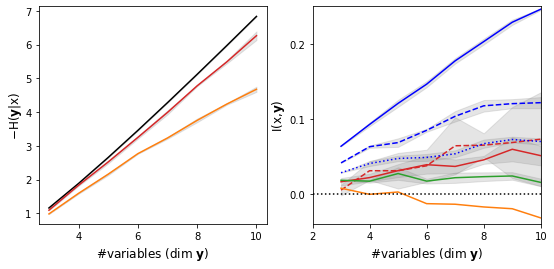

In [6]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_student(Hrs,Hr):
    
    with open("../../benchmarks/redo_again_StudentH.pkl",'rb') as f:
        results = pkl.load(f)
        
    Ns = np.array([res['Nvar'] for res in results])
    nNs = np.array([res['Nvar'] for res in results])

    line(Hrs,Ns,np.array([res["true_HRgS"].mean() for res in results]),d = 0.005*np.ones(len(results)),
         label="True",cut=Ns.max(), color='k')
    line(Hrs,nNs,np.array([-res["eC"].mean() for res in results]),d = 0.005*np.ones(len(results)),
         label="Copula-GP",cut=nNs.max(), color='C3')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(), color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

#     line(Hr,Ns,np.array([res["true_integral"][0] for res in results]),
#          d = 0.005*np.ones(len(results)), label="True",cut=Ns.max(),color="black")
#     line(Hr,Ns,np.array([res["integrated"] for res in results]), color='C3', 
#          d = 0.005*np.ones(len(results)), label="Copula-GP integr.",cut=Ns.max())
    line(Hr,nNs,np.array([res["integrated"] for res in results]), color='C3', 
         d = 0.005*np.ones(len(results)), label="Copula-GP integr.",cut=nNs.max())
    
#     line(Hr,Ns,np.array([res["estimated"] for res in results]), color='C3', 
#              d=np.array([0.005*np.sqrt(2) for res in results]), linestyle='dashed',
#          label="Copula-GP estim.",cut=Ns.max())
    line(Hr,nNs,np.array([res["estimated"] for res in results]), color='C3', 
             d=np.array([0.005*np.sqrt(2) for res in results]), linestyle='dashed',
         label="Copula-GP estim.",cut=nNs.max())
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),color='C1',alpha=0)
#     line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),
#          color='C1',linestyle='dashed')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(),color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(), color='blue',linestyle='dotted')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='blue',linestyle='dashed')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='blue')

    for a in [Hrs,Hr]:  
        a.set_xlabel("#variables (dim $\mathbf{y}$)", fontsize=12)
#     Hrs.yaxis.tick_right()
#     Hrs.xaxis.tick_top()
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{y}$|x)",labelpad=1, fontsize=12)
#     Hrs.tick_params(axis="y",direction="in", pad=-15)
    Hr.set_ylabel("I(x,$\mathbf{y}$)",labelpad=3,fontsize=12)
    Hr.set_ylim(-0.04,0.25)
    Hr.set_xlim(2,10)
    Hr.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    Hr.set_yticks(np.arange(0.,0.201,0.1),minor=False)
    Hr.set_yticklabels([f"{i:.1f}" for i in np.arange(0.,0.201,0.1)])
#     Hr.tick_params(axis="y",direction="in", pad=-30)
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.axhline(0,color='k',linestyle='dotted')
#     Hrs.legend(frameon=False);
    #legend(frameon=False,loc=(-4.,0.42), fontsize=7.3);
plot_student(Hrs,Hr)

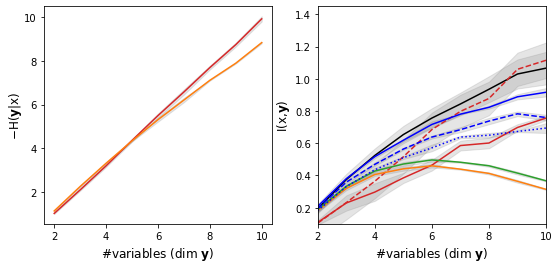

In [7]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_complex(Hrs,Hr):

    with open("../../benchmarks/tomerge/transformed_Gauss_I.pkl",'rb') as f:
        results = pkl.load(f)
    
    Ns = np.array([res['Nvar'] for res in results])
    nNs = np.array([res['Nvar'] for res in results])

    line(Hrs,nNs,np.array([-res["eC"].mean() for res in results]),d = 0.01*nNs,
         label="CopulaGP",cut=nNs.max(),color='C3')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(), color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")
    
    line(Hr,Ns,np.array([res["true_integral"] for res in results]),
         d = 0.01*Ns, label="True",cut=Ns.max(),color="black")
#     line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, 
#          label="CopulaGP integr.",cut=Ns.max(),color='C3')
    line(Hr,nNs,np.array([res["integrated"] for res in results]), color='C3', 
         d = 0.01*np.ones(len(results)), label="Copula-GP integr.",cut=nNs.max())
    
#     line(Hr,Ns,np.array([res["estimated"] for res in results]), 
#              d=np.array([(results[-1]['gauss_eU'].std()+0.05*Ns*np.sqrt(2)) for res in results]),
#          label="CopulaGP estim.",cut=Ns.max(),color='C3',linestyle='dashed')
    line(Hr,nNs,np.array([res["estimated"] for res in results]), color='C3', 
             d=np.array([results[-1]['eU'].std()+0.05*np.sqrt(2) for res in results]), linestyle='dashed',
         label="Copula-GP estim.",cut=nNs.max())
    
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),color='C1')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(),color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(),color='blue',linestyle='dotted')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='blue',linestyle='dashed')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='blue')

    for a in [Hrs,Hr]:  
        a.set_xlabel("#variables (dim $\mathbf{y}$)", fontsize=12)
#     Hrs.yaxis.tick_right()
#     Hrs.xaxis.tick_top()
    Hr.set_ylim(0.1,1.45)
    Hr.set_xlim(2,10)
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{y}$|x)",labelpad=0, fontsize=12)
#     Hrs.tick_params(axis="y",direction="in", pad=-25)
    Hr.set_ylabel("I(x,$\mathbf{y}$)",labelpad=3, fontsize=12)
#     Hr.tick_params(axis="y",direction="in", pad=-25)
#     Hrs.legend(frameon=False);
#     Hr.legend(frameon=True,loc=(1.02,0.17));
    Hr.axhline(0,color='k',linestyle='dotted')
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     Hr.legend(bbox_to_anchor=(-1.5, 1.2, 3, .102), loc=3,
#        ncol=8, mode="expand", borderaxespad=0., fontsize=12)

plot_complex(Hrs,Hr)

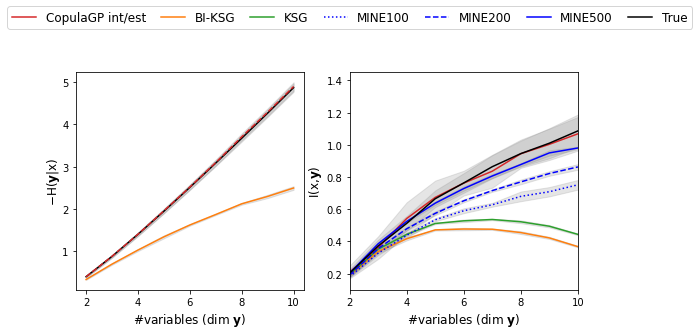

In [9]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_gauss(Hrs,Hr):
    
    results_file = f"../../benchmarks/redo_GaussH.pkl"
    with open(results_file,'rb') as f:
        results = pkl.load(f)  
        
    Ns = np.array([res['Nvar'] for res in results])

    line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,
         label="True",cut=Ns.max(),color='k')
    line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,
         label="CopulaGP",cut=Ns.max(),color='C3', linestyle='dashed')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(),color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

    line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, 
         label="CopulaGP int/est",cut=Ns.max(),color='C3')
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(), color='C1')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(), color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(),color='blue',linestyle='dotted')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='blue',linestyle='dashed')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='blue')

    line(Hr,Ns,np.array([res["true_integral"] for res in results]),
         d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

    for a in [Hrs,Hr]:  
        a.set_xlabel("#variables (dim $\mathbf{y}$)", fontsize=12)
#     Hrs.yaxis.tick_right()
#     Hrs.xaxis.tick_top()
    Hr.set_ylim(0.1,1.45)
    Hr.set_xlim(2,10)
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{y}$|x)",labelpad=0, fontsize=12)
    Hr.set_ylabel("I(x,$\mathbf{y}$)",labelpad=3, fontsize=12)
#     Hr.tick_params(axis="y",direction="in", pad=-25)
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    Hr.legend(bbox_to_anchor=(-1.5, 1.2, 3, .102), loc=3,
       ncol=8, mode="expand", borderaxespad=0., fontsize=12)
    Hr.axhline(0,color='k',linestyle='dotted')
#     Hrs.legend(frameon=False);
#    Hr.legend(frameon=False);
plot_gauss(Hrs,Hr)


In [15]:
results_file = f"../../benchmarks/redo_GaussH.pkl"
with open(results_file,'rb') as f:
    all_results = pkl.load(f) 
results = []
for res in all_results:
    if res['Nvar']==10:
        results.append(res)
for key in ['integrated','BI-KSG','KSG','MINE100','MINE500','estimated']:
    # mean OF (!) a ratio (not ratio of means)
    ratio = np.mean([res[key]/res['true_integral'] for res in results]) # true[0] for student
    abs = np.mean([res[key]-res['true_integral'] for res in results])
    print(key,abs,int(np.round(100*ratio)),'%') 

integrated -0.018080512682596844 98 %
BI-KSG -0.7184635610232077 34 %
KSG -0.6423869559868286 41 %
MINE100 -0.3346058443693655 69 %
MINE500 -0.10607178659041032 90 %
estimated 1.2082935571670532 211 %


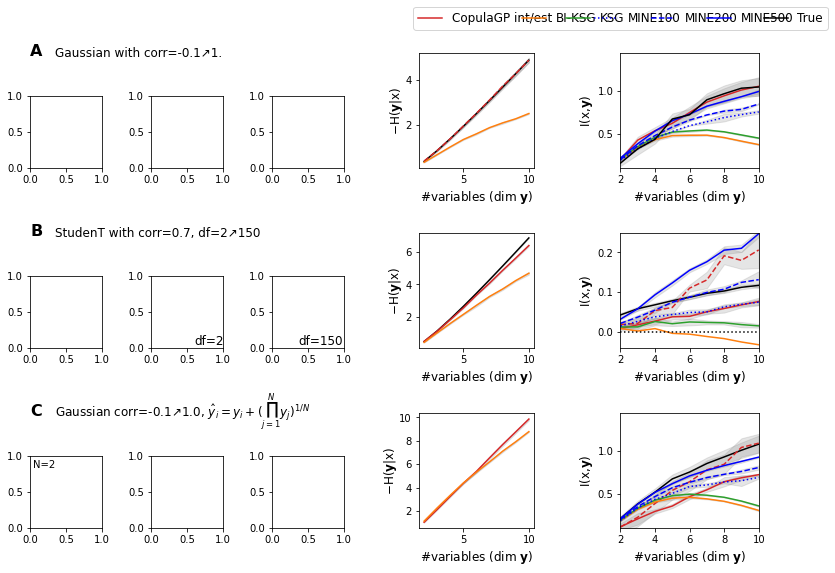

In [32]:
fig_width, fig_height = 11, 7.8
aspect = fig_width/fig_height
fig = plt.figure(figsize=(fig_width,fig_height))

l_mrg, b_mrg = 0.5/fig_width, aspect*5.5/fig_width
dens_size = 1./fig_width
dens_y = b_mrg #+ 3.2/fig_height
block_size = 4./fig_width
plot_width, plot_height = 1.6*dens_size, 1.6*dens_size*aspect
next_block = 0#block_size+0.8/fig_width
plot_shift = 2.2*block_size+dens_size-plot_width 
plot_shift_n = 1.5*block_size+dens_size-plot_width
# such that the right edge of the MI plot matches the last density plot
next_panel = 2.5/fig_height

def plot_dataset(axes,data):
    
    (axA,ax0,ax1) = axes
    pos = axA.get_position()

    fig.text(pos.x0+0.31*pos.width*4,pos.y0+0.45*pos.height,'=',fontsize="16")
    fig.text(pos.x0+0.72*pos.width*4,pos.y0+0.45*pos.height,'⟶',fontsize="14")
    axA.set_title('p($\mathbf{u}$)')
    ax0.set_title('p($\mathbf{u}$|x=0)')
    ax1.set_title('p($\mathbf{u}$|x=1)')
    for ax in [ax0,ax1]:
        ax.set_xticks([], [])
        ax.set_yticks([], [])

    for ax,d in zip(axes,data):
        sns.kdeplot(*d.T, ax=ax, n_levels=n_levels, \
                    cmap=None, colors='black', alpha=0.5, shade=False)

    axA.set_xticks([0,1])
    axA.set_yticks([0,1])
    axA.set_xticklabels([0,1])
    
# ax0 = fig.add_axes([0,0,1,1])

G_dA = fig.add_axes([l_mrg+0,dens_y,             dens_size,dens_size*aspect])
G_d0 = fig.add_axes([l_mrg+0.42*block_size,dens_y,dens_size,dens_size*aspect])
G_d1 = fig.add_axes([l_mrg+0.84*block_size,dens_y,dens_size,dens_size*aspect])
# plot_dataset((G_dA,G_d0,G_d1),[sample_gauss(np.linspace(-0.1,1.,NSamp)),
#                                sample_gauss(-0.1*np.ones(NSamp)),
#                                sample_gauss(1.0*np.ones(NSamp))])


S_dA = fig.add_axes([l_mrg+next_block+0,dens_y-next_panel,             dens_size,dens_size*aspect])
S_d0 = fig.add_axes([l_mrg+next_block+0.42*block_size,dens_y-next_panel,dens_size,dens_size*aspect])
S_d1 = fig.add_axes([l_mrg+next_block+0.84*block_size,dens_y-next_panel,dens_size,dens_size*aspect])
# plot_dataset((S_dA,S_d0,S_d1),[sample_student(0.7*np.ones(NSamp),np.exp(5*np.linspace(0,1,NSamp))+1),
#                                sample_student(0.7*np.ones(NSamp),2.*np.ones(NSamp)),
#                                sample_student(0.7*np.ones(NSamp),150.*np.ones(NSamp))])

H_dA = fig.add_axes([l_mrg+2*next_block+0,dens_y-2*next_panel,             dens_size,dens_size*aspect])
H_d0 = fig.add_axes([l_mrg+2*next_block+0.42*block_size,dens_y-2*next_panel,dens_size,dens_size*aspect])
H_d1 = fig.add_axes([l_mrg+2*next_block+0.84*block_size,dens_y-2*next_panel,dens_size,dens_size*aspect])
# plot_dataset((H_dA,H_d0,H_d1),[sample_complex(np.linspace(-0.1,1.,NSamp),Nvar=2)[:,[-2,-1]],
#                             sample_complex(-0.1*np.ones(NSamp),Nvar=2)[:,[-2,-1]],
#                             sample_complex(1.0*np.ones(NSamp),Nvar=2)[:,[-2,-1]]])

G_Hr  = fig.add_axes([l_mrg+plot_shift,b_mrg,plot_width*1.2,plot_height])
G_Hrs = fig.add_axes([l_mrg+plot_shift_n, b_mrg,plot_width,plot_height])
fig.text(l_mrg,dens_y+dens_size*aspect*1.55,"A",fontsize=16,fontweight='bold')
fig.text(l_mrg+dens_size*0.35,dens_y+dens_size*aspect*1.54,"Gaussian with corr=-0.1↗1.",fontsize=12)
plot_gauss(G_Hrs,G_Hr)

S_Hr  = fig.add_axes([l_mrg+next_block+plot_shift,b_mrg-next_panel,plot_width*1.2,plot_height])
S_Hrs = fig.add_axes([l_mrg+next_block+plot_shift_n, b_mrg-next_panel,plot_width,plot_height])
fig.text(l_mrg,dens_y-next_panel+dens_size*aspect*1.55,"B",fontsize=16,fontweight='bold')
fig.text(l_mrg+dens_size*0.35,dens_y-next_panel+dens_size*aspect*1.54,
         "StudenT with corr=0.7, df=2↗150",fontsize=12);
plot_student(S_Hrs,S_Hr)

fig.text(l_mrg + next_block + 0.57*block_size,dens_y-next_panel + 0.04*dens_size*aspect,'df=2',fontsize=12)
fig.text(l_mrg + next_block + 0.93*block_size,dens_y-next_panel + 0.04*dens_size*aspect,'df=150',fontsize=12)

H_Hr  = fig.add_axes([l_mrg+2*next_block+plot_shift,b_mrg-2*next_panel,plot_width*1.2,plot_height])
H_Hrs = fig.add_axes([l_mrg+2*next_block+plot_shift_n, b_mrg-2*next_panel,plot_width,plot_height])
fig.text(l_mrg,dens_y-2*next_panel+dens_size*aspect*1.55,"C",fontsize=16,fontweight='bold')
fig.text(l_mrg+dens_size*0.35,dens_y-2*next_panel+dens_size*aspect*1.54,
         "Gaussian corr=-0.1↗1.0, $\hat{y}_i = y_i + (\prod_{j=1}^{N} y_j)^{1/N}$",fontsize=12);
plot_complex(H_Hrs,H_Hr)
fig.text(l_mrg + 2*next_block+0.01*block_size,dens_y-2*next_panel + 0.83*dens_size*aspect,'N=2')
H_Hrs.set_yticks([2,4,6,8,10])

In [33]:
fig.savefig("../../benchmarks/synthetic_result.pdf")

In [ ]:
results_file = f"../../benchmarks/ClaytonH.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
# results_file = f"ClaytonH_back.pkl"
# with open(results_file,'rb') as f:
#     results += pkl.load(f)   
Ns = np.array([res['Nvar'] for res in results])

fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

results[0]

line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,label="True",cut=Ns.max())
line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,label="Copula-GP",cut=Ns.max())
line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),label="BI-KSG",cut=Ns.max())
# line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, label="Copula-GP integrated",cut=Ns.max())
line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max())

line(Hr,Ns,np.array([res["true_integral"] for res in results]),
     d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

for a in [Hrs,Hr]:
    a.set_xlabel(r"#variables (dim $\mathbf{y}$)")
Hrs.set_ylabel("$-\int H(\mathbf{y}|x)p(x)dx$")
Hr.set_ylabel("$MI(x,y)$")
Hr.set_title("Clayton with corr=0.↗2.")
Hr.set_ylim(-0.02,1.65)
Hrs.legend();
Hr.legend(loc=(1.1,0.5));